# Scalar Property in the UTC

In [1]:
import os
import sys

%pylab inline
import pylab

import nengo
from nengo.utils.ensemble import response_curves, tuning_curves
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry

import numpy as np
import pandas as pd
import itertools
import string
import scipy
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['lines.marker'] = ''
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3


In [3]:
# UTC_prospective contains main functions for simulating the UTC model
%run ../UTC_prospective.py

## Scalar Property for time production

### Scaling input noise with sqrt(theta) to get timescale invariance

In [4]:
# set parameters
n_trials = 250
target_intervals = np.logspace(-2, 4, num=7, base=2)
m_list = np.array([2, 3, 4]) # 2 gives CV of around 0.1

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [5]:
target_intervals

array([ 0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  ])

In [6]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, m in itertools.product(target_intervals, m_list):
            u_noise = m * np.sqrt(target_interval) # scale input noise with sqrt(theta)
            UTC_prospective().run(task_type='prospective_motor',
                                 dimensions=1,
                                 prestim=0.,
                                 seed=trial,
                                 verbose=False,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=0.,
                                 input_noise_std=u_noise,
                                 within_gain_noise_std=0.,
                                 data_dir='square_root_scaling',
                                 ID = m)
            trial += 1

In [7]:
if get_dat_method == 'simulate':
    square_root_scaling_data = pytry.read('square_root_scaling')
    square_root_scaling_dt_raw = pd.DataFrame(square_root_scaling_data)
    square_root_scaling_dt_raw.to_csv('square_root_scaling.csv')

In [8]:
square_root_scaling_dt_raw = pd.read_csv('square_root_scaling.csv')

In [9]:
square_root_scaling_dt_raw['norm_rt'] = (square_root_scaling_dt_raw['rt']/1000 / square_root_scaling_dt_raw['effective_theta'])

# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
square_root_scaling_dt = pd.DataFrame()
var_independent = 0 # variance independent of target time
square_root_scaling_dt['mean'] = square_root_scaling_dt_raw.groupby(['effective_theta', 'ID'])['rt'].mean()
square_root_scaling_dt['mean^2'] = square_root_scaling_dt['mean']**2
square_root_scaling_dt['var'] = square_root_scaling_dt_raw.groupby(['effective_theta', 'ID'])['rt'].var() 
square_root_scaling_dt['var'] = square_root_scaling_dt['var'] + var_independent
square_root_scaling_dt['std'] = np.sqrt(square_root_scaling_dt['var'])
square_root_scaling_dt['cv'] = square_root_scaling_dt['std'] / square_root_scaling_dt['mean']
square_root_scaling_dt = square_root_scaling_dt.reset_index()


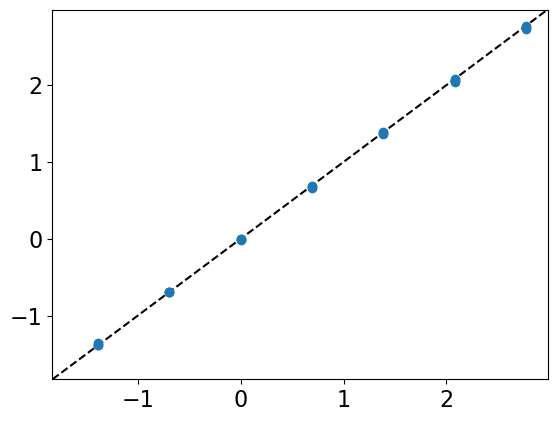

In [10]:
condition = (square_root_scaling_dt['ID']==0.1)
plt.scatter(np.log(square_root_scaling_dt['effective_theta']), 
            np.log(square_root_scaling_dt['mean']/1000))
plt.axline((np.log(0.2), np.log(0.2)), slope=1, ls='dashed', color='k', zorder=0)


In [11]:
square_root_scaling_dt

,effective_theta,ID,mean,mean^2,var,std,cv
0,0.25,2,251.886598,6.344686e+04,7.443078e+02,27.282005,0.108311
1,0.25,3,256.340206,6.571030e+04,1.753315e+03,41.872603,0.163348
2,0.25,4,250.711340,6.285618e+04,3.049344e+03,55.220865,0.220257
3,0.50,2,500.512027,2.505123e+05,3.428058e+03,58.549617,0.116979
4,0.50,3,501.865979,2.518695e+05,6.276703e+03,79.225644,0.157862
5,0.50,4,498.367698,2.483704e+05,1.126203e+04,106.122728,0.212941
6,1.00,2,1000.295533,1.000591e+06,1.106584e+04,105.194313,0.105163
7,1.00,3,1000.295533,1.000591e+06,2.647309e+04,162.705537,0.162657
8,1.00,4,987.611684,9.753768e+05,5.482694e+04,234.151536,0.237089
9,2.00,2,1979.661765,3.919061e+06,4.819067e+04,219.523729,0.110890


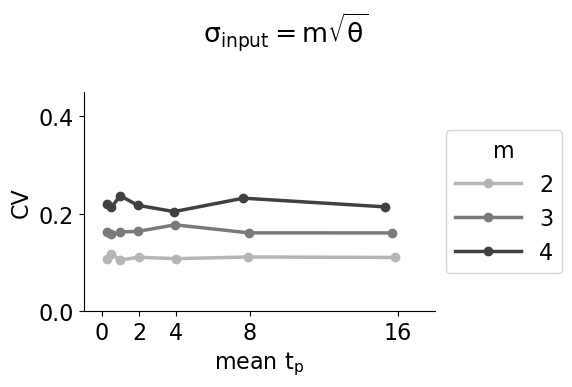

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_p$', fontsize=16)
ax.set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

colors = plt.cm.Greys(np.linspace(0.4, 1, 4))
for i in range(0,len(m_list)):
    conditions = (square_root_scaling_dt['ID']==round(m_list[i], 2))
    x = square_root_scaling_dt[conditions]['mean'].values
    cv = square_root_scaling_dt[conditions]['cv'].values

    ax.plot(x/1000, cv, lw=2.5, color=colors[i],
               label=str(round(m_list[i], 1)),
               marker='o')

    ax.set_ylim([0, 0.45])

    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#ax.set_xscale('log', base=2)
ax.set_xticks([0, 2, 4, 8, 16])
ax.set_xlim([-1, 18])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='m', fontsize=16)
plt.setp(legend.get_title(),fontsize=16)
        
plt.suptitle(r'$\sigma_{input} = m\sqrt{\theta}$')
fig.tight_layout()
plt.savefig('cv_constant.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')


### Constant input noise to explain decreasing CV

In [13]:
# set parameters
n_trials = 250
target_intervals = np.logspace(-2, 4, num=7, base=2)
m_list = np.array([2, 3, 4]) # 2 gives CV of around 0.1

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [14]:
target_intervals

array([ 0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  ])

In [15]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, m in itertools.product(target_intervals, m_list):
            u_noise = m # constant input noise
            UTC_prospective().run(task_type='prospective_motor',
                                 dimensions=1,
                                 prestim=0.,
                                 seed=trial,
                                 verbose=False,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=0.,
                                 input_noise_std=u_noise,
                                 within_gain_noise_std=0.,
                                 data_dir='constant_noise',
                                 ID = m)
            trial += 1

In [16]:
if get_dat_method == 'simulate':
    constant_noise_data = pytry.read('constant_noise')
    constant_noise_dt_raw = pd.DataFrame(constant_noise_data)
    constant_noise_dt_raw.to_csv('constant_noise.csv')

In [17]:
constant_noise_dt_raw = pd.read_csv('constant_noise.csv')

In [18]:
constant_noise_dt_raw['norm_rt'] = (constant_noise_dt_raw['rt']/1000 / constant_noise_dt_raw['effective_theta'])

# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
constant_noise_dt = pd.DataFrame()
var_independent = 0 # variance independent of target time
constant_noise_dt['mean'] = constant_noise_dt_raw.groupby(['effective_theta', 'ID'])['rt'].mean()
constant_noise_dt['mean^2'] = constant_noise_dt['mean']**2
constant_noise_dt['var'] = constant_noise_dt_raw.groupby(['effective_theta', 'ID'])['rt'].var() 
constant_noise_dt['var'] = constant_noise_dt['var'] + var_independent
constant_noise_dt['std'] = np.sqrt(constant_noise_dt['var'])
constant_noise_dt['cv'] = constant_noise_dt['std'] / constant_noise_dt['mean']
constant_noise_dt = constant_noise_dt.reset_index()


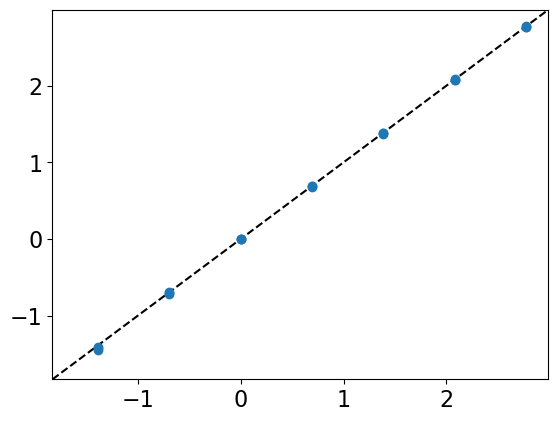

In [19]:
condition = (constant_noise_dt['ID']==0.1)
plt.scatter(np.log(constant_noise_dt['effective_theta']), 
            np.log(constant_noise_dt['mean']/1000))
plt.axline((np.log(0.2), np.log(0.2)), slope=1, ls='dashed', color='k', zorder=0)


In [20]:
constant_noise_dt

,effective_theta,ID,mean,mean^2,var,std,cv
0,0.25,2,240.076,5.763649e+04,2934.142795,54.167728,0.225627
1,0.25,3,246.268,6.064793e+04,5582.759213,74.717864,0.303401
2,0.25,4,235.228,5.533221e+04,8319.421703,91.210864,0.387755
3,0.50,2,499.224,2.492246e+05,6523.933558,80.770871,0.161793
4,0.50,3,495.380,2.454013e+05,11118.614056,105.444839,0.212856
5,0.50,4,491.224,2.413010e+05,19087.106249,138.156094,0.281249
6,1.00,2,999.008,9.980170e+05,12599.228851,112.246287,0.112358
7,1.00,3,1006.636,1.013316e+06,24973.790667,158.030980,0.156989
8,1.00,4,1004.060,1.008136e+06,52879.984337,229.956484,0.229027
9,2.00,2,1996.888,3.987562e+06,26859.449253,163.888527,0.082072


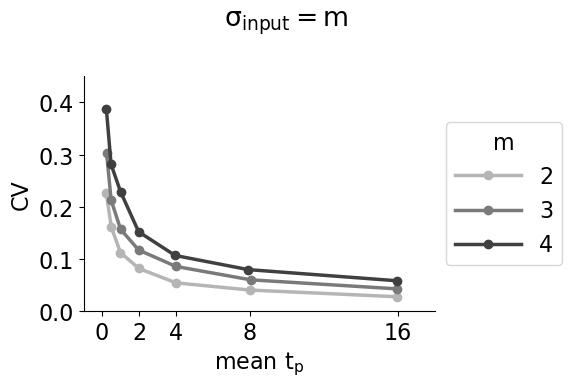

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_p$', fontsize=16)
ax.set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

colors = plt.cm.Greys(np.linspace(0.4, 1, 4))
for i in range(0,len(m_list)):
    conditions = (constant_noise_dt['ID']==round(m_list[i], 2))
    x = constant_noise_dt[conditions]['mean'].values
    cv = constant_noise_dt[conditions]['cv'].values

    ax.plot(x/1000, cv, lw=2.5, color=colors[i],
               label=str(round(m_list[i], 1)),
               marker='o')

    ax.set_ylim([0, 0.45])

    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#ax.set_xscale('log', base=2)
ax.set_xticks([0, 2, 4, 8, 16])
ax.set_xlim([-1, 18])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='m', fontsize=16)
plt.setp(legend.get_title(),fontsize=16)
        
plt.suptitle(r'$\sigma_{input} = m$')
fig.tight_layout()
plt.savefig('cv_decreasing.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')


### Noise in 1/theta to account for increases in CV

In [22]:
# set parameters
n_trials = 250
target_intervals = np.logspace(-2, 4, num=7, base=2)
m = 2 # 2 gives CV of around 0.1
bg_noise_list = np.array([0.01, 0.02, 0.03])

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [23]:
target_intervals

array([ 0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  ])

In [24]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, bg_noise in itertools.product(target_intervals, bg_noise_list):
            u_noise = m * np.sqrt(target_interval) # scale input noise with sqrt(theta)
            UTC_prospective().run(task_type='prospective_motor',
                                 dimensions=1,
                                 prestim=0.,
                                 seed=trial,
                                 verbose=False,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=bg_noise,
                                 input_noise_std=u_noise,
                                 within_gain_noise_std=0.,
                                 data_dir='bg_scaling',
                                 ID = bg_noise)
            trial += 1

In [25]:
if get_dat_method == 'simulate':
    bg_scaling_data = pytry.read('bg_scaling')
    bg_scaling_dt_raw = pd.DataFrame(bg_scaling_data)
    bg_scaling_dt_raw.to_csv('bg_scaling.csv')

In [26]:
bg_scaling_dt_raw = pd.read_csv('bg_scaling.csv')

In [27]:
bg_scaling_dt_raw['norm_rt'] = (bg_scaling_dt_raw['rt']/1000 / bg_scaling_dt_raw['effective_theta'])

# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
bg_scaling_dt = pd.DataFrame()
var_independent = 0 # variance independent of target time
bg_scaling_dt['mean'] = bg_scaling_dt_raw.groupby(['effective_theta', 'ID'])['rt'].mean()
bg_scaling_dt['mean^2'] = bg_scaling_dt['mean']**2
bg_scaling_dt['var'] = bg_scaling_dt_raw.groupby(['effective_theta', 'ID'])['rt'].var() 
bg_scaling_dt['var'] = bg_scaling_dt['var'] + var_independent
bg_scaling_dt['std'] = np.sqrt(bg_scaling_dt['var'])
bg_scaling_dt['cv'] = bg_scaling_dt['std'] / bg_scaling_dt['mean']
bg_scaling_dt = bg_scaling_dt.reset_index()


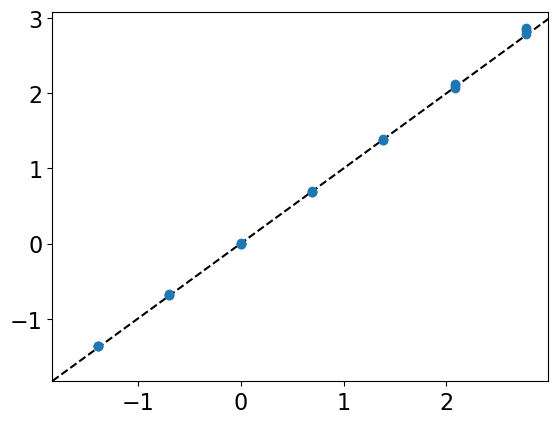

In [28]:
condition = (bg_scaling_dt['ID']==0.1)
plt.scatter(np.log(bg_scaling_dt['effective_theta']), 
            np.log(bg_scaling_dt['mean']/1000))
plt.axline((np.log(0.2), np.log(0.2)), slope=1, ls='dashed', color='k', zorder=0)


In [29]:
bg_scaling_dt

,effective_theta,ID,mean,mean^2,var,std,cv
0,0.25,0.01,254.780000,6.491285e+04,8.375378e+02,28.940244,0.113589
1,0.25,0.02,256.712000,6.590105e+04,8.170894e+02,28.584776,0.111350
2,0.25,0.03,256.080000,6.557697e+04,8.148771e+02,28.546052,0.111473
3,0.50,0.01,507.992000,2.580559e+05,3.392257e+03,58.243085,0.114654
4,0.50,0.02,505.608000,2.556394e+05,3.106721e+03,55.737969,0.110239
5,0.50,0.03,505.456000,2.554858e+05,3.022876e+03,54.980684,0.108774
6,1.00,0.01,999.236000,9.984726e+05,1.121286e+04,105.890811,0.105972
7,1.00,0.02,994.592000,9.892132e+05,1.249826e+04,111.795611,0.112403
8,1.00,0.03,1007.544000,1.015145e+06,1.621572e+04,127.340955,0.126387
9,2.00,0.01,1983.064000,3.932543e+06,5.766675e+04,240.139024,0.121095


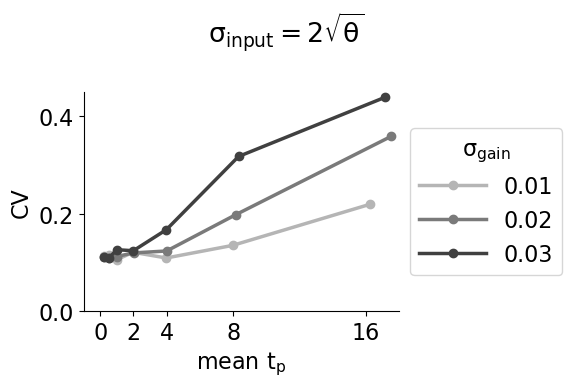

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_p$', fontsize=16)
ax.set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

colors = plt.cm.Greys(np.linspace(0.4, 1, 4))
for i in range(0,len(bg_noise_list)):
    conditions = (bg_scaling_dt['ID']==round(bg_noise_list[i], 2))
    x = bg_scaling_dt[conditions]['mean'].values
    cv = bg_scaling_dt[conditions]['cv'].values

    ax.plot(x/1000, cv, lw=2.5, color=colors[i],
               label=str(round(bg_noise_list[i], 3)),
               marker='o')

    ax.set_ylim([0, 0.45])

    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#ax.set_xscale('log', base=2)
ax.set_xticks([0, 2, 4, 8, 16])
ax.set_xlim([-1, 18])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=r'$\sigma_{{gain}}$', 
                   fontsize=16)
plt.setp(legend.get_title(),fontsize=16)
        
plt.suptitle(r'$\sigma_{input} = 2\sqrt{\theta}$')
fig.tight_layout()
plt.savefig('cv_increasing.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')


### Superimposition of response time distributions (Simen et al., 2016)

In [31]:
# set parameters
n_trials = 1000
target_intervals = np.array([2.2, 5.1, 11.3]) # Simen et al. (2016)
m_list = np.array([4]) # m=4 gives CV of around 0.2
#m_list = np.arange(0.1, 0.5, 0.1)

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [32]:
target_intervals

array([ 2.2,  5.1, 11.3])

In [33]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, m in itertools.product(target_intervals, m_list):
            u_noise = m * np.sqrt(target_interval) # scale input noise with sqrt(theta)
            UTC_prospective().run(task_type='prospective_motor',
                                 dimensions=1,
                                 prestim=0.,
                                 seed=trial,
                                 verbose=False,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=0.,
                                 input_noise_std=u_noise,
                                 within_gain_noise_std=0.,
                                 data_dir='simen_2016',
                                 ID = m)
            trial += 1

In [34]:
if get_dat_method == 'simulate':
    simen_2016_data = pytry.read('simen_2016')
    simen_2016_dt_raw = pd.DataFrame(simen_2016_data)
    simen_2016_dt_raw.to_csv('simen_2016.csv')

In [35]:
simen_2016_dt_raw = pd.read_csv('simen_2016.csv')

In [36]:
simen_2016_dt_raw['norm_rt'] = (simen_2016_dt_raw['rt']/1000 / simen_2016_dt_raw['effective_theta'])

# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
simen_2016_dt = pd.DataFrame()
var_independent = 0 # variance independent of target time
simen_2016_dt['mean'] = simen_2016_dt_raw.groupby(['effective_theta', 'ID'])['rt'].mean()
simen_2016_dt['mean^2'] = simen_2016_dt['mean']**2
simen_2016_dt['var'] = simen_2016_dt_raw.groupby(['effective_theta', 'ID'])['rt'].var() 
simen_2016_dt['var'] = simen_2016_dt['var'] + var_independent
simen_2016_dt['std'] = np.sqrt(simen_2016_dt['var'])
simen_2016_dt['cv'] = simen_2016_dt['std'] / simen_2016_dt['mean']
simen_2016_dt = simen_2016_dt.reset_index()


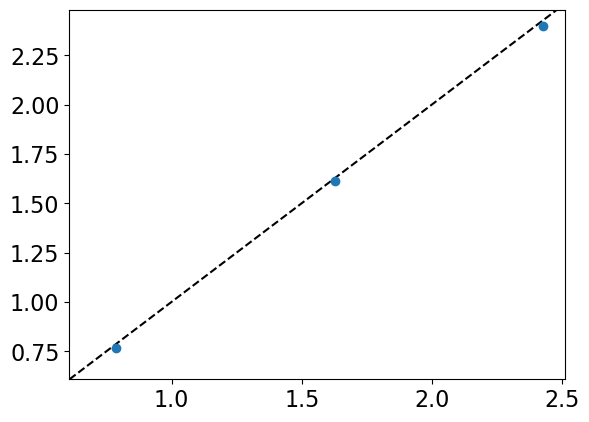

In [37]:
condition = (simen_2016_dt['ID']==0.1)
plt.scatter(np.log(simen_2016_dt['effective_theta']), 
            np.log(simen_2016_dt['mean']/1000))
plt.axline((np.log(2), np.log(2)), slope=1, ls='dashed', color='k', zorder=0)


In [38]:
simen_2016_dt

,effective_theta,ID,mean,mean^2,var,std,cv
0,2.2,4,2147.104,4.610056e+06,2.063115e+05,454.215236,0.211548
1,5.1,4,5005.267,2.505270e+07,1.161436e+06,1077.699179,0.215313
2,11.3,4,10972.802,1.204024e+08,5.327157e+06,2308.063463,0.210344


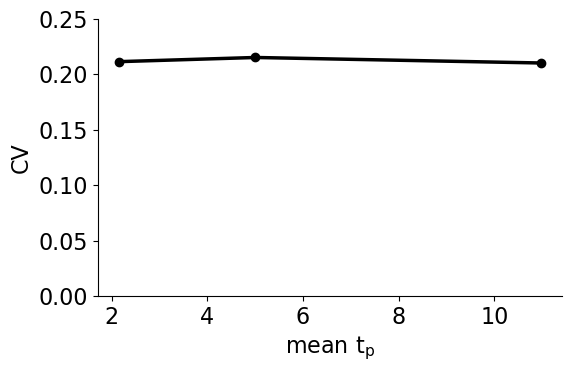

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_p$', fontsize=16)
ax.set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

colors = plt.cm.Greys(np.linspace(0.4, 1, 4))
for i in range(0,len(m_list)):
    conditions = (simen_2016_dt['ID']==round(m_list[i], 2))
    x = simen_2016_dt[conditions]['mean'].values
    cv = simen_2016_dt[conditions]['cv'].values

    ax.plot(x/1000, cv, lw=2.5, color='black',
               label=str(round(m_list[i], 1)),
               marker='o')

    ax.set_ylim([0, 0.25])

    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#ax.set_xlim([0, 500000])
#ax.set_xscale('log', base=2)
#ax.set_xticks([1, 2, 4, 8, 16, 32])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#legend = ax.legend(title='m', fontsize=14)
plt.setp(legend.get_title(),fontsize=16)
        
#plt.suptitle('Time Production', y=1.05, fontsize=18)
fig.tight_layout()
plt.savefig('cv_constant.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')


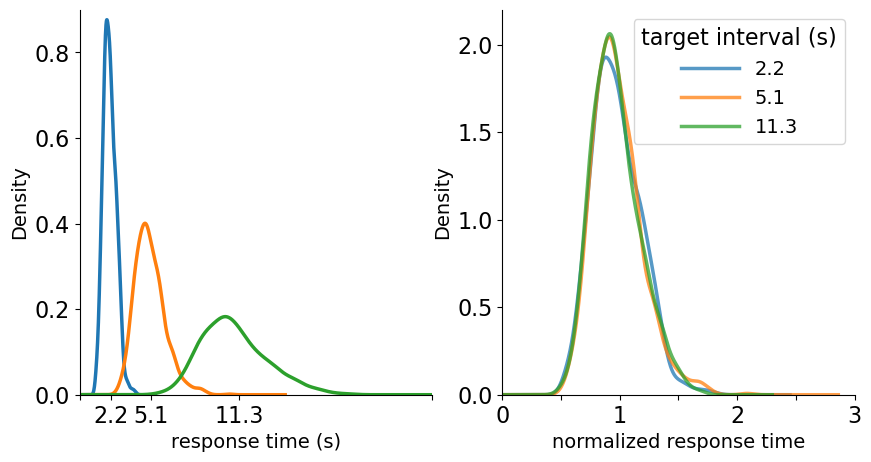

In [40]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=2, sharey=False, sharex=False)
cmap = cm.get_cmap('Spectral')
simen_2016_dt_raw['rts'] = simen_2016_dt_raw['rt'] / 1000
simen_2016_dt_raw.groupby('effective_theta')['rts'].plot(
    kind='density',
    legend=False,
    ax=axes[0],
    xlim=0,
    lw=2.5,
    alpha=1)

simen_2016_dt_raw.groupby('effective_theta')['norm_rt'].plot(
    kind='density',
    legend=False,
    ax=axes[1],
    xlim=0,
    lw=2.5,
    alpha=0.75)


axes[0].set_xticks([0, 2.2, 5.1, 11.3, 25])
axes[0].set_xticklabels(['', '2.2', '5.1', '11.3', ''])
axes[0].set_xlabel("response time (s)")
axes[0].set_ylim([0, 0.9])

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

lines, labels = axes[1].get_legend_handles_labels()
axes[1].legend(lines[:3], labels[:3], loc='best', title='target interval (s)')

axes[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
axes[1].set_xticklabels(['0', '', '1', '', '2', '', '3'])
axes[1].set_xlabel("normalized response time")
axes[1].set_ylim([0, 2.2])

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

fig.savefig('simen_2016.png', dpi=400, bbox_inches='tight')
#axes.axvline(1, ls='dashed', color='k')

In [41]:
from scipy import stats

In [42]:
# Kolmogorov-Smirnoff test, comparing normalized rt distributions

conditions1 = (simen_2016_dt_raw['effective_theta']==2.2) 
samples1 = simen_2016_dt_raw[conditions1]['norm_rt']

conditions2 = (simen_2016_dt_raw['effective_theta']==5.1)
samples2 = simen_2016_dt_raw[conditions2]['norm_rt']

conditions3 = (simen_2016_dt_raw['effective_theta']==11.3)
samples3 = simen_2016_dt_raw[conditions3]['norm_rt']

print(stats.ks_2samp(samples1, samples2))
print('')
print(stats.ks_2samp(samples1, samples3))
print('')
print(stats.ks_2samp(samples2, samples3))

KstestResult(statistic=0.038, pvalue=0.4659595288557257, statistic_location=1.1462745098039218, statistic_sign=-1)

KstestResult(statistic=0.036, pvalue=0.5362766985932181, statistic_location=0.9908849557522122, statistic_sign=-1)

KstestResult(statistic=0.031, pvalue=0.7228251828701066, statistic_location=1.0223008849557522, statistic_sign=-1)


In [43]:
print(stats.skew(samples1))
print(stats.skew(samples2))
print(stats.skew(samples3))

0.5286285905433102
0.8943676857088022
0.5963284371073269


## Scalar property time perception

### Scaling input noise with sqrt(theta) to get timescale invariance

In [44]:
# set parameters
n_trials = 250
target_intervals = np.logspace(-2, 4, num=7, base=2)
m_list = np.array([2, 3, 4]) # 2 gives CV of around 0.1

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [45]:
target_intervals

array([ 0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  ])

In [46]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, m in itertools.product(target_intervals, m_list):
            u_noise = m * np.sqrt(target_interval) # scale input noise with sqrt(theta)
            UTC_prospective().run(task_type='prospective_sensory',
                                 dimensions=1,
                                 prestim=0.,
                                 seed=trial,
                                 verbose=False,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=0.,
                                 input_noise_std=u_noise,
                                 within_gain_noise_std=0.,
                                  poststim=0,
                                  trial_duration=target_interval,
                                 data_dir='square_root_scaling_perception',
                                 ID = m)
            trial += 1

In [47]:
if get_dat_method == 'simulate':
    square_root_scaling_data = pytry.read('square_root_scaling_perception')
    square_root_scaling_dt_raw = pd.DataFrame(square_root_scaling_data)
    square_root_scaling_dt_raw.to_csv('square_root_scaling_perception.csv')

In [48]:
square_root_scaling_dt_raw = pd.read_csv('square_root_scaling_perception.csv')

In [49]:
square_root_scaling_dt_raw['norm_estimate'] = square_root_scaling_dt_raw['estimate']/0.63 * square_root_scaling_dt_raw['effective_theta']

# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
square_root_scaling_dt = pd.DataFrame()
var_independent = 0 # variance independent of target time
square_root_scaling_dt['mean'] = square_root_scaling_dt_raw.groupby(['effective_theta', 'ID'])['norm_estimate'].mean()
square_root_scaling_dt['mean^2'] = square_root_scaling_dt['mean']**2
square_root_scaling_dt['var'] = square_root_scaling_dt_raw.groupby(['effective_theta', 'ID'])['norm_estimate'].var() 
square_root_scaling_dt['var'] = square_root_scaling_dt['var'] + var_independent
square_root_scaling_dt['std'] = np.sqrt(square_root_scaling_dt['var'])
square_root_scaling_dt['cv'] = square_root_scaling_dt['std'] / square_root_scaling_dt['mean']
square_root_scaling_dt = square_root_scaling_dt.reset_index()


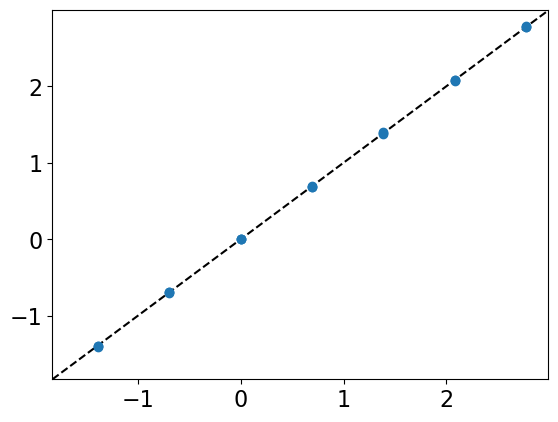

In [50]:
condition = (square_root_scaling_dt['ID']==0)
plt.scatter(np.log(square_root_scaling_dt['effective_theta']), 
            np.log(square_root_scaling_dt['mean']))
plt.axline((np.log(0.2), np.log(0.2)), slope=1, ls='dashed', color='k', zorder=0)


In [51]:
square_root_scaling_dt

,effective_theta,ID,mean,mean^2,var,std,cv
0,0.25,2,0.247858,0.061433,0.000253,0.015892,0.064117
1,0.25,3,0.244998,0.060024,0.000585,0.024193,0.098747
2,0.25,4,0.246637,0.060830,0.000922,0.030371,0.123139
3,0.50,2,0.499019,0.249020,0.001249,0.035342,0.070824
4,0.50,3,0.498266,0.248269,0.002374,0.048726,0.097791
5,0.50,4,0.499263,0.249264,0.004813,0.069378,0.138960
6,1.00,2,0.998728,0.997457,0.004026,0.063452,0.063533
7,1.00,3,0.998927,0.997855,0.009833,0.099164,0.099270
8,1.00,4,1.001593,1.003188,0.020020,0.141493,0.141268
9,2.00,2,1.994055,3.976254,0.020211,0.142167,0.071295


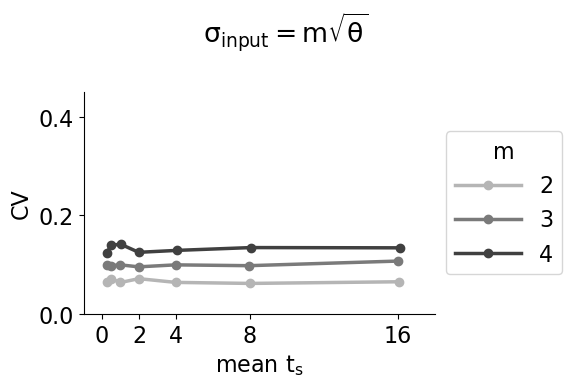

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_s$', fontsize=16)
ax.set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

colors = plt.cm.Greys(np.linspace(0.4, 1, 4))
for i in range(0,len(m_list)):
    conditions = (square_root_scaling_dt['ID']==round(m_list[i], 2))
    x = square_root_scaling_dt[conditions]['mean'].values
    cv = square_root_scaling_dt[conditions]['cv'].values

    ax.plot(x, cv, lw=2.5, color=colors[i],
               label=str(round(m_list[i], 1)),
               marker='o')

    ax.set_ylim([0, 0.45])

    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#ax.set_xscale('log', base=2)
ax.set_xticks([0, 2, 4, 8, 16])
ax.set_xlim([-1, 18])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='m', fontsize=16)
plt.setp(legend.get_title(),fontsize=16)
        
plt.suptitle(r'$\sigma_{input} = m\sqrt{\theta}$')
fig.tight_layout()
plt.savefig('cv_constant_perception.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')


### Constant input noise to explain decreasing CV

In [53]:
# set parameters
n_trials = 250
target_intervals = np.logspace(-2, 4, num=7, base=2)
m_list = np.array([2, 3, 4]) # 2 gives CV of around 0.1

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [54]:
target_intervals

array([ 0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  ])

In [55]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, m in itertools.product(target_intervals, m_list):
            u_noise = m # constant input noise
            UTC_prospective().run(task_type='prospective_sensory',
                                 dimensions=1,
                                 prestim=0.,
                                 seed=trial,
                                 verbose=False,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=0.,
                                 input_noise_std=u_noise,
                                 within_gain_noise_std=0.,
                                  poststim=0,
                                  trial_duration=target_interval,
                                 data_dir='constant_noise_perception',
                                 ID = m)
            trial += 1

In [56]:
if get_dat_method == 'simulate':
    constant_noise_data = pytry.read('constant_noise_perception')
    constant_noise_dt_raw = pd.DataFrame(constant_noise_data)
    constant_noise_dt_raw.to_csv('constant_noise_perception.csv')

In [57]:
constant_noise_dt_raw = pd.read_csv('constant_noise_perception.csv')

In [58]:
constant_noise_dt_raw['norm_estimate'] = constant_noise_dt_raw['estimate']/0.63 * constant_noise_dt_raw['effective_theta']

# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
constant_noise_dt = pd.DataFrame()
var_independent = 0 # variance independent of target time
constant_noise_dt['mean'] = constant_noise_dt_raw.groupby(['effective_theta', 'ID'])['norm_estimate'].mean()
constant_noise_dt['mean^2'] = constant_noise_dt['mean']**2
constant_noise_dt['var'] = constant_noise_dt_raw.groupby(['effective_theta', 'ID'])['norm_estimate'].var() 
constant_noise_dt['var'] = constant_noise_dt['var'] + var_independent
constant_noise_dt['std'] = np.sqrt(constant_noise_dt['var'])
constant_noise_dt['cv'] = constant_noise_dt['std'] / constant_noise_dt['mean']
constant_noise_dt = constant_noise_dt.reset_index()


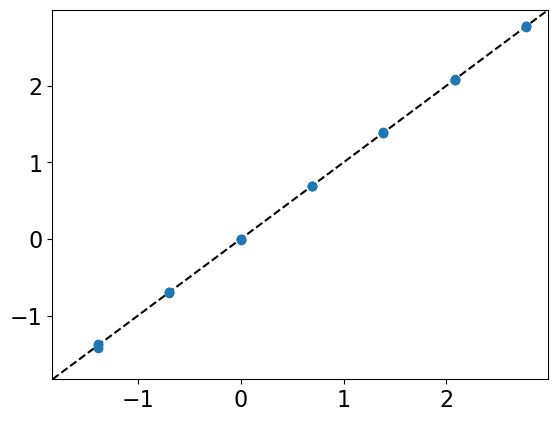

In [59]:
condition = (constant_noise_dt['ID']==0.1)
plt.scatter(np.log(constant_noise_dt['effective_theta']), 
            np.log(constant_noise_dt['mean']))
plt.axline((np.log(0.2), np.log(0.2)), slope=1, ls='dashed', color='k', zorder=0)


In [60]:
constant_noise_dt

,effective_theta,ID,mean,mean^2,var,std,cv
0,0.25,2,0.250517,0.062759,0.001255,0.035432,0.141434
1,0.25,3,0.242596,0.058853,0.002250,0.047434,0.195526
2,0.25,4,0.254915,0.064982,0.004569,0.067592,0.265154
3,0.50,2,0.500475,0.250475,0.002344,0.048412,0.096733
4,0.50,3,0.499214,0.249215,0.004804,0.069313,0.138845
5,0.50,4,0.493487,0.243530,0.009249,0.096169,0.194877
6,1.00,2,0.994919,0.989865,0.004285,0.065459,0.065794
7,1.00,3,1.005636,1.011305,0.009817,0.099079,0.098524
8,1.00,4,0.993087,0.986222,0.018764,0.136983,0.137936
9,2.00,2,2.001057,4.004229,0.009715,0.098567,0.049257


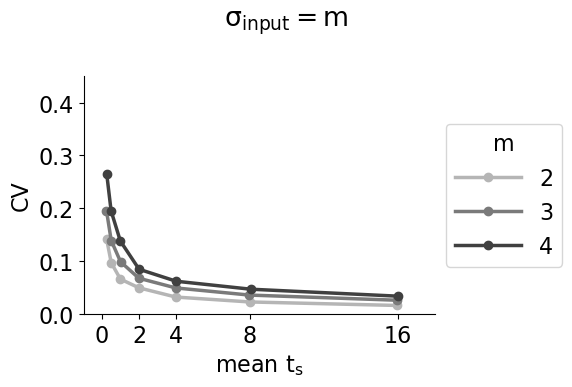

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_s$', fontsize=16)
ax.set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

colors = plt.cm.Greys(np.linspace(0.4, 1, 4))
for i in range(0,len(m_list)):
    conditions = (constant_noise_dt['ID']==round(m_list[i], 2))
    x = constant_noise_dt[conditions]['mean'].values
    cv = constant_noise_dt[conditions]['cv'].values

    ax.plot(x, cv, lw=2.5, color=colors[i],
               label=str(round(m_list[i], 1)),
               marker='o')

    ax.set_ylim([0, 0.45])

    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#ax.set_xscale('log', base=2)
ax.set_xticks([0, 2, 4, 8, 16])
ax.set_xlim([-1, 18])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='m', fontsize=16)
plt.setp(legend.get_title(),fontsize=16)
        
plt.suptitle(r'$\sigma_{input} = m$')
fig.tight_layout()
plt.savefig('cv_decreasing_perception.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')


### Noise in 1/theta to account for increases in CV

In [62]:
# set parameters
n_trials = 250
target_intervals = np.logspace(-2, 4, num=7, base=2)
m = 2 # 2 gives CV of around 0.1
bg_noise_list = np.array([0.01, 0.02, 0.03])

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [63]:
target_intervals

array([ 0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  ])

In [64]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, bg_noise in itertools.product(target_intervals, bg_noise_list):
            u_noise = m * np.sqrt(target_interval) # scale input noise with sqrt(theta)
            UTC_prospective().run(task_type='prospective_sensory',
                                 dimensions=1,
                                 prestim=0.,
                                 seed=trial,
                                 verbose=False,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=bg_noise,
                                 input_noise_std=u_noise,
                                 within_gain_noise_std=0.,
                                  poststim=0,
                                  trial_duration=target_interval,
                                 data_dir='bg_scaling_perception',
                                 ID = bg_noise)
            trial += 1

In [65]:
if get_dat_method == 'simulate':
    bg_scaling_data = pytry.read('bg_scaling_perception')
    bg_scaling_dt_raw = pd.DataFrame(bg_scaling_data)
    bg_scaling_dt_raw.to_csv('bg_scaling_perception.csv')

In [66]:
bg_scaling_dt_raw = pd.read_csv('bg_scaling_perception.csv')

In [67]:
bg_scaling_dt_raw['norm_estimate'] = bg_scaling_dt_raw['estimate']/0.63 * bg_scaling_dt_raw['effective_theta']

# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
bg_scaling_dt = pd.DataFrame()
var_independent = 0 # variance independent of target time
bg_scaling_dt['mean'] = bg_scaling_dt_raw.groupby(['effective_theta', 'ID'])['rt'].mean()
bg_scaling_dt['mean^2'] = bg_scaling_dt['mean']**2
bg_scaling_dt['var'] = bg_scaling_dt_raw.groupby(['effective_theta', 'ID'])['rt'].var() 
bg_scaling_dt['var'] = bg_scaling_dt['var'] + var_independent
bg_scaling_dt['std'] = np.sqrt(bg_scaling_dt['var'])
bg_scaling_dt['cv'] = bg_scaling_dt['std'] / bg_scaling_dt['mean']
bg_scaling_dt = bg_scaling_dt.reset_index()


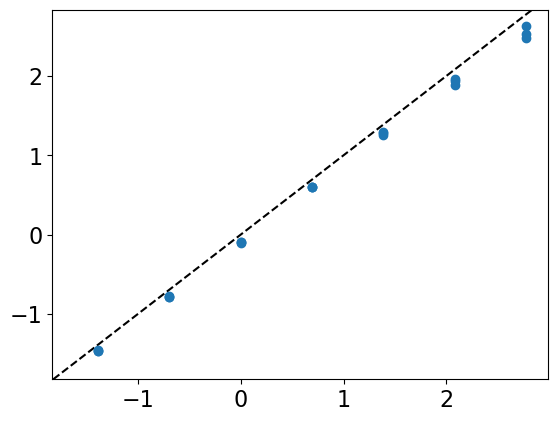

In [68]:
condition = (bg_scaling_dt['ID']==0.1)
plt.scatter(np.log(bg_scaling_dt['effective_theta']), 
            np.log(bg_scaling_dt['mean']/1000))
plt.axline((np.log(0.2), np.log(0.2)), slope=1, ls='dashed', color='k', zorder=0)


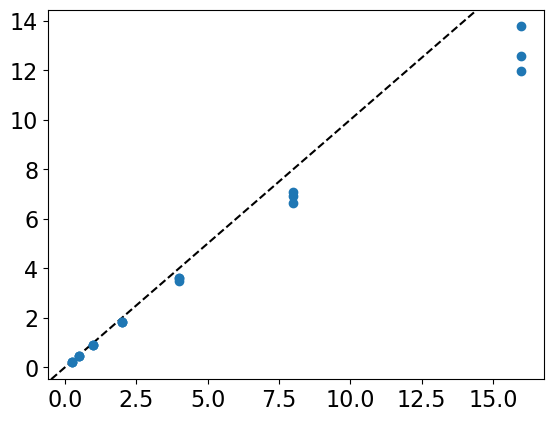

In [69]:
plt.scatter(bg_scaling_dt['effective_theta'], 
            bg_scaling_dt['mean']/1000)
plt.axline([0.2, 0.2], slope=1, ls='dashed', color='k', zorder=0)


In [70]:
bg_scaling_dt

,effective_theta,ID,mean,mean^2,var,std,cv
0,0.25,0.01,231.495726,5.359027e+04,1.920625e+02,13.858661,0.059866
1,0.25,0.02,232.862385,5.422489e+04,1.622864e+02,12.739170,0.054707
2,0.25,0.03,231.313043,5.350572e+04,1.717432e+02,13.105085,0.056655
3,0.50,0.01,457.288889,2.091131e+05,8.760129e+02,29.597516,0.064724
4,0.50,0.02,461.314050,2.128107e+05,6.957839e+02,26.377716,0.057180
5,0.50,0.03,458.944000,2.106296e+05,9.114404e+02,30.190071,0.065782
6,1.00,0.01,911.379032,8.306117e+05,3.486384e+03,59.045606,0.064787
7,1.00,0.02,904.810606,8.186822e+05,3.846567e+03,62.020697,0.068546
8,1.00,0.03,911.664062,8.311314e+05,3.717516e+03,60.971437,0.066879
9,2.00,0.01,1825.552239,3.332641e+06,1.621073e+04,127.321366,0.069744


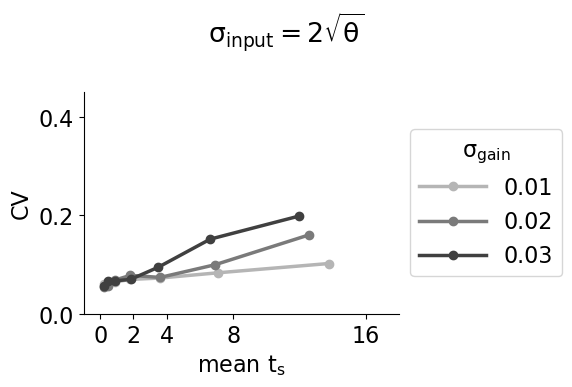

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_s$', fontsize=16)
ax.set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

colors = plt.cm.Greys(np.linspace(0.4, 1, 4))
for i in range(0,len(bg_noise_list)):
    conditions = (bg_scaling_dt['ID']==round(bg_noise_list[i], 2))
    x = bg_scaling_dt[conditions]['mean'].values
    cv = bg_scaling_dt[conditions]['cv'].values

    ax.plot(x/1000, cv, lw=2.5, color=colors[i],
               label=str(round(bg_noise_list[i], 3)),
               marker='o')

    ax.set_ylim([0, 0.45])

    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#ax.set_xscale('log', base=2)
ax.set_xticks([0, 2, 4, 8, 16])
ax.set_xlim([-1, 18])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=r'$\sigma_{{gain}}$', 
                   fontsize=16)
plt.setp(legend.get_title(),fontsize=16)
        
plt.suptitle(r'$\sigma_{input} = 2\sqrt{\theta}$')
fig.tight_layout()
plt.savefig('cv_increasing_perception.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')
